### 🧠 What is Query Planning and Decomposition?
Query Planning and Decomposition is a technique where a complex user query is broken down into simpler sub-questions or tasks, allowing a system (like a RAG agent) to:

- Understand the question more deeply
- Retrieve more precise and complete information
- Execute step-by-step reasoning

It's like reverse-engineering a question into manageable steps before answering.

🧠 What's New in This Version?
- ✅ Add a Query Planner Node
- ✅ Break complex user queries into sub-questions
- ✅ Retrieve docs per sub-question
- ✅ Combine all retrieved contexts
- ✅ Generate a final consolidated answer

In [1]:
import os
from typing import List
from pydantic import BaseModel
from langchain_openai import OpenAIEmbeddings
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores.faiss import FAISS
from langchain_community.document_loaders import TextLoader,WebBaseLoader
from langgraph.graph import StateGraph, END

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
import os
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
load_dotenv()
llm = ChatOpenAI(model="gpt-4o")

In [3]:
# ----------------------------
# 1. Load and Embed Documents
# ----------------------------
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/"
]
docs = []
for url in urls:
    docs.extend(WebBaseLoader(url).load())

splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_documents(docs)

embedding = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(chunks, embedding)
retriever = vectorstore.as_retriever()


In [4]:
# ----------------------------
# 2. State Schema
# ----------------------------
class RAGState(BaseModel):
    question: str
    sub_questions: List[str] = []
    retrieved_docs: List[Document] = []
    answer: str = ""

In [5]:
# ----------------------------
# 3. Nodes
# ----------------------------

## a. Query Planner: splits input question
def plan_query(state: RAGState) -> RAGState:
   
    prompt = f"""
Break the following complex question into 2-3 sub-questions:

Question: {state.question}

Sub-questions:
"""
    result = llm.invoke(prompt)
    sub_questions = [line.strip("- ").strip() for line in result.content.strip().split("\n") if line.strip()]
    return RAGState(question=state.question, sub_questions=sub_questions)

## b. Retrieve documents for each sub-question
def retrieve_for_each(state: RAGState) -> RAGState:
    all_docs = []
    for sub in state.sub_questions:
        docs = retriever.invoke(sub)
        all_docs.extend(docs)
    return RAGState(question=state.question, sub_questions=state.sub_questions, retrieved_docs=all_docs)

## c. Generate final answer
def generate_final_answer(state: RAGState) -> RAGState:
    context = "\n\n".join([doc.page_content for doc in state.retrieved_docs])
    prompt = f"""
Use the context below to answer the question.

Context:
{context}

Question: {state.question}
"""
    
    answer = llm.invoke(prompt).content
    return RAGState(question=state.question, sub_questions=state.sub_questions, retrieved_docs=state.retrieved_docs, answer=answer)


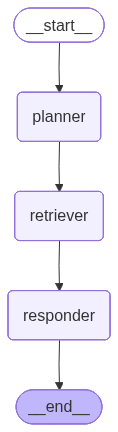

In [6]:
# ----------------------------
# 4. Build LangGraph
# ----------------------------
builder = StateGraph(RAGState)

builder.add_node("planner", plan_query)
builder.add_node("retriever", retrieve_for_each)
builder.add_node("responder", generate_final_answer)

builder.set_entry_point("planner")
builder.add_edge("planner", "retriever")
builder.add_edge("retriever", "responder")
builder.add_edge("responder", END)

graph = builder.compile()
graph

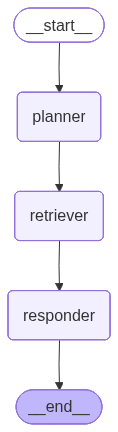

In [7]:
graph

In [8]:
# ----------------------------
# 5. Run the pipeline
# ----------------------------
if __name__ == "__main__":
    user_query = "Explain how agent loops work and what are the challenges in diffusion video generation?"
    initial_state = RAGState(question=user_query)
    final_state = graph.invoke(initial_state)
    print(final_state)

    print("\n🔍 Sub-questions:")
    for q in final_state['sub_questions']:
        print("-", q)

    print("\n✅ Final Answer:\n", final_state['answer'])

{'question': 'Explain how agent loops work and what are the challenges in diffusion video generation?', 'sub_questions': ['1. What are agent loops, and how do they function within a broader system?', '2. What are the typical challenges encountered in the process of diffusion video generation?', '3. How do agent loops specifically impact or interact with the challenges faced in diffusion video generation?'], 'retrieved_docs': [Document(id='ce937509-2fd1-4543-923c-a3b26e5dc053', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\